# Learning to Learn w\ Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/QOSF-Mentorship/blob/main/l2l_0.ipynb)

This it the first jupyter notebook used to familiarize with _Pennylane_ and _RNNs_ and _LSTMs_.

At first, the QAOA example for MAXCUT will be implemented.

**Run cell below only if using this notebook in Colab**  
Installing required dependencies and packages

In [ ]:
IS_COLAB = False
if IS_COLAB:
    !pip install --upgrade qiskit
    !pip install --upgrade pennylane
    !pip install networkx

#### Importation of required packages

In [49]:
import pennylane as qml
import qiskit as qk
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Set the seed for reproducibility of results

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Generation of data: graphs

Generation of a rangom graph $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs
- $p$ is the probability of creation of an edge between two nodes

In [11]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

Sample of a generted graph with 7 nodes and 11 edges (p=0.43)


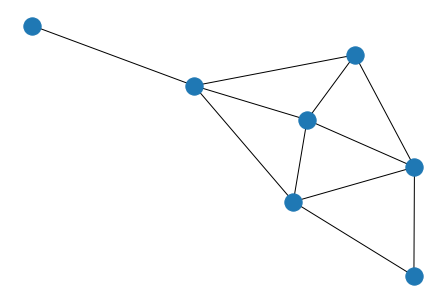

In [59]:
# Define parameters of the graph
n_graphs = 10
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Sample of a generted graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

## Mapping of Graph to QAOA anstaze

How to create a circuit in Pennylane

In [88]:
dev = qml.device('default.qubit', wires=2, shots=1024, analytic=False)

@qml.qnode(dev)
def circuit():
    qml.PauliX(1)
    qml.Hadamard(0)
    return qml.expval(qml.PauliZ(1))

circuit()
print(circuit.draw())

 0: ──H──┤     
 1: ──X──┤ ⟨Z⟩ 



In [180]:
# Transverse field
def U_x(eta, n_wires = None):
    for wire in range(n_wires):
        qml.RX(2 * eta, wires = wire)

# Actual hamiltonian
def U_C(gamma, graph = None):
    for edge in graph.edges():
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def qaoa_from_graph(alphas, betas, graph = None, p = None):
    n_qubits = len(graph.nodes)
    
    # All qubits to |+> state
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Repeat QAOA ansatze p times
    for n_layers in range(p):
        for e in graph.edges():
            qml.CZ(wires = [e[0], e[1]])
            
    # Final measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

dev = dev = qml.device('default.qubit', wires=7, shots=1024, analytic=False)

qnode = qml.QNode(qaoa_from_graph, dev)

qnode(0., 0., graph = graphs[0], p = 1)

print(qnode.draw())

 0: ──H──╭C──╭C──────────────────────────────────────┤ ⟨Z⟩ 
 1: ──H──╰Z──│───╭C──────╭C──────╭C──────────────────┤ ⟨Z⟩ 
 2: ──H──────│───│───╭C──│───╭C──│───────╭C──────────┤ ⟨Z⟩ 
 3: ──H──────╰Z──╰Z──╰Z──│───│───│───╭C──│───────────┤ ⟨Z⟩ 
 4: ──H──────────────────╰Z──╰Z──│───╰Z──│───╭C──────┤ ⟨Z⟩ 
 5: ──H──────────────────────────│───────│───│───╭C──┤ ⟨Z⟩ 
 6: ──H──────────────────────────╰Z──────╰Z──╰Z──╰Z──┤ ⟨Z⟩ 

